In [ ]:
# Cell 1: create Mollweide grid clipped to land mask

import os
import math
import numpy as np
import geopandas as gpd
from shapely.geometry import box
import pyproj
import gc

land_mask_path = r"E:\planetscope_lake_ice\Data\Input\Land Mask\World_Countries_Generalized.shp"  # vector land mask
grid_cell_size_km = 50  # cell size in km
output_dir = r"E:\planetscope_lake_ice\Data\Input\Global Mollweide Grid"

os.makedirs(output_dir, exist_ok=True)

# Mollweide CRS (proj string) and CRS objects
moll_proj4 = "+proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
moll_crs = moll_proj4

# read land mask vector and reproject to Mollweide
print("Reading land mask (vector) and reprojecting to Mollweide...")
land = gpd.read_file(land_mask_path)
land = land.to_crs(moll_crs)

# get bounding box for grid generation (use dissolved geometry bounds)
land_union = land.unary_union
minx, miny, maxx, maxy = land_union.bounds

# build grid parameters
cell_size_m = int(grid_cell_size_km * 1000)  # convert km to meters
# add one cell buffer so edges are included
minx -= cell_size_m
miny -= cell_size_m
maxx += cell_size_m
maxy += cell_size_m

nx = int(math.ceil((maxx - minx) / cell_size_m))
ny = int(math.ceil((maxy - miny) / cell_size_m))
print(f"Grid cells (cols x rows): {nx} x {ny}  -> approx {nx*ny} total")

# generate grid (keep only cells that intersect the land mask bounds)
cells = []
cell_ids = []
rows = []
cols = []
cid = 0
x = minx
for i in range(nx):
    y = miny
    for j in range(ny):
        geom = box(x, y, x + cell_size_m, y + cell_size_m)
        if geom.intersects(land_union):  # keep cell if it intersects land mask area
            cells.append(geom)
            cell_ids.append(cid)
            rows.append(j)
            cols.append(i)
            cid += 1
        y += cell_size_m
    x += cell_size_m

grid_gdf = gpd.GeoDataFrame({
    "cell_id": cell_ids,
    "row": rows,
    "col": cols,
    "lake_count": [0]*len(cells),
    "geometry": cells
}, crs=moll_crs)

print(f"Kept {len(grid_gdf)} grid cells after intersecting land mask")

# Save grid (filename includes km size)
grid_filename = f"mollweide_grid_{grid_cell_size_km}km_clipped.shp"
grid_path = os.path.join(output_dir, grid_filename)
print("Saving grid to:", grid_path)
grid_gdf.to_file(grid_path)

gc.collect()
print("Cell 1 finished.")


Reading land mask (vector) and reprojecting to Mollweide...
Grid cells (cols x rows): 713 x 357  -> approx 254541 total
Kept 65647 grid cells after intersecting land mask
Saving grid to: E:\planetscope_lake_ice\Data\Input\50x50km Global Mollweide Grid\mollweide_grid_50km_clipped.shp
Cell 1 finished.


In [7]:
# Single-pass, R-tree backed lake counting (fast)
import os
import gc
import json
from tqdm import tqdm

import geopandas as gpd
import numpy as np
from rtree import index
from osgeo import ogr
import pyproj
from shapely import wkb
from shapely.ops import transform
from shapely.geometry import shape

# -------------------------
# USER PATHS / PARAMETERS
# -------------------------
gdb_path = r"E:\planetscope_lake_ice\Data\Input\PLD\SWOT_PLD_v201_02042025_attributes_updated.gdb"
grid_path = r"E:\planetscope_lake_ice\Data\Input\Global Mollweide Grid\mollweide_grid_50km_clipped.shp"
output_dir = r"E:\planetscope_lake_ice\Data\Input\Global Mollweide Grid"
final_grid_path = os.path.join(output_dir, "mollweide_grid_50km_with_lake_counts.shp")
csv_out = os.path.join(output_dir, "mollweide_grid_50km_with_lake_counts.csv")
# If you want to limit to a subset for testing, set test_n_lakes to an integer; else None
test_n_lakes = None
# -------------------------

os.makedirs(output_dir, exist_ok=True)

# Load grid (should already be Mollweide); ensure CRS matches Mollweide proj used elsewhere
moll_proj4 = "+proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
grid = gpd.read_file(grid_path)
if grid.crs is None:
    raise RuntimeError("Grid file has no CRS; ensure it was saved with a CRS.")
grid = grid.to_crs(moll_proj4)  # ensure same CRS

n_cells = len(grid)
print(f"Loaded grid: {n_cells} cells")

# Build rtree index for grid by bounding box
print("Building R-tree index for grid bounds...")
grid_idx = index.Index()
for i, geom in enumerate(grid.geometry):
    grid_idx.insert(i, geom.bounds)

# Prepare counters
counts = np.zeros(n_cells, dtype=int)

# Open PLD geodatabase once for streaming read
ds = ogr.Open(gdb_path, 0)
if ds is None:
    raise RuntimeError(f"Cannot open GDB: {gdb_path}")

# Choose PLD layer (prefer a name containing 'PLD', else first)
layer = None
for li in range(ds.GetLayerCount()):
    l = ds.GetLayerByIndex(li)
    lname = (l.GetName() or "").upper()
    if "PLD" in lname:
        layer = l
        break
if layer is None:
    layer = ds.GetLayerByIndex(0)
print("Using PLD layer:", layer.GetName())

# Determine layer CRS and set up transformer from layer CRS -> Mollweide
layer_srs = layer.GetSpatialRef()
if layer_srs is not None:
    try:
        layer_wkt = layer_srs.ExportToWkt()
        layer_crs = pyproj.CRS.from_wkt(layer_wkt)
    except Exception:
        layer_crs = pyproj.CRS.from_epsg(4326)
else:
    layer_crs = pyproj.CRS.from_epsg(4326)

MOLL = pyproj.CRS.from_proj4(moll_proj4)
transformer = pyproj.Transformer.from_crs(layer_crs, MOLL, always_xy=True)

# Helper transform function for shapely.ops.transform
def _transform_to_moll(x, y, z=None):
    return transformer.transform(x, y)

# We will stream features; count total (if possible) for progress bar
try:
    total_features = layer.GetFeatureCount()
except Exception:
    total_features = None

print("Iterating PLD features once and assigning to grid via R-tree...")
layer.ResetReading()

# Single-pass over features
feat_iter = layer
i_processed = 0
for feat in tqdm(feat_iter, total=total_features, desc="PLD features"):
    i_processed += 1
    if test_n_lakes is not None and i_processed > test_n_lakes:
        break

    geom_ref = feat.GetGeometryRef()
    if geom_ref is None:
        continue

    # Export to WKB and load into shapely
    try:
        wkb_bytes = geom_ref.ExportToWkb()
        lake_geom_src = wkb.loads(wkb_bytes)  # geometry in layer CRS
    except Exception:
        # fallback using GeoJSON parsing
        try:
            geojson = geom_ref.ExportToJson()
            lake_geom_src = shape(json.loads(geojson))
        except Exception:
            continue

    # Transform lake geometry to Mollweide (so grid and lake share CRS)
    try:
        lake_geom_moll = transform(_transform_to_moll, lake_geom_src)
    except Exception:
        # If transform fails, skip
        continue

    # Candidate grid cells via rtree by bounds intersection
    try:
        candidate_idxs = list(grid_idx.intersection(lake_geom_moll.bounds))
    except Exception:
        continue

    # Test if lake is completely within any candidate cell (stop at first)
    # Note: use .within so lake must be entirely inside cell (including boundary)
    assigned = False
    for ci in candidate_idxs:
        cell_geom = grid.geometry.iloc[ci]
        try:
            if lake_geom_moll.within(cell_geom):
                counts[ci] += 1
                assigned = True
                break
        except Exception:
            # invalid geometry / topology errors: skip this candidate
            continue

# Close datasource
ds = None

# Attach counts and save outputs
grid["lake_count"] = counts
print("Saving final grid with counts to:", final_grid_path)
grid.to_file(final_grid_path)

print("Saving CSV:", csv_out)
grid.drop(columns="geometry").to_csv(csv_out, index=False)

# Print summary
total_lakes = int(counts.sum())
n_nonzero = int((counts > 0).sum())
max_in_cell = int(counts.max()) if n_cells>0 else 0
avg_nonzero = float(counts[counts>0].mean()) if n_nonzero>0 else 0.0

print("="*40)
print("DONE")
print(f"Processed PLD features: ~{i_processed}")
print(f"Total lakes counted (within cells): {total_lakes}")
print(f"Cells with lakes: {n_nonzero} / {n_cells}")
print(f"Max lakes in a cell: {max_in_cell}")
print(f"Avg lakes per non-empty cell: {avg_nonzero:.2f}")
print("="*40)

gc.collect()


Loaded grid: 65647 cells
Building R-tree index for grid bounds...
Using PLD layer: SWOT_PLD_v201_02042025_attributes_updated
Iterating PLD features once and assigning to grid via R-tree...


PLD features: 100%|██████████| 5897941/5897941 [46:04<00:00, 2133.57it/s]  


Saving final grid with counts to: E:\planetscope_lake_ice\Data\Input\Global Mollweide Grid\mollweide_grid_50km_with_lake_counts.shp
Saving CSV: E:\planetscope_lake_ice\Data\Input\Global Mollweide Grid\mollweide_grid_50km_with_lake_counts.csv
DONE
Processed PLD features: ~5897941
Total lakes counted (within cells): 5767238
Cells with lakes: 42397 / 65647
Max lakes in a cell: 4705
Avg lakes per non-empty cell: 136.03


59

In [13]:
import cdsapi
import os

# --- USER PATHS ---
cds_config = r"D:\planetscope_lake_ice\.cdsapirc"   # path to your .cdsapirc file
output_dir = r"E:\planetscope_lake_ice\Data\Input"  # where to save the .nc file
output_file = os.path.join(output_dir, "ERA5_t2m_monthly_1991_2020.nc")
# ------------------

# optional: ensure CDS API knows where config file is
os.environ["CDSAPI_RC"] = cds_config

# create client
c = cdsapi.Client()

# ERA5 monthly mean 2m temperature request
c.retrieve(
    "reanalysis-era5-single-levels-monthly-means",
    {
        "product_type": "monthly_averaged_reanalysis",
        "variable": "2m_temperature",
        "year": [str(y) for y in range(1991, 2021)],  # 1991–2020
        "month": [f"{m:02d}" for m in range(1, 13)],
        "time": "00:00",
        "format": "netcdf",
    },
    output_file,
)

print("Saved ERA5 monthly mean temperature to:", output_file)


2025-10-06 15:37:40,622 INFO Request ID is 8afe18c1-27db-4250-9365-2ff3f7400e4c
2025-10-06 15:37:40,922 INFO status has been updated to accepted
2025-10-06 15:37:49,740 INFO status has been updated to running
2025-10-06 15:38:57,415 INFO status has been updated to successful


74514e4bde6465a04b4a3ccff4b50dc7.nc:   0%|          | 0.00/467M [00:00<?, ?B/s]

Saved ERA5 monthly mean temperature to: E:\planetscope_lake_ice\Data\Input\ERA5_t2m_monthly_1991_2020.nc


In [5]:
# Single cell: create binary mask (>=2 months below 0°C) and save as Mollweide GeoTIFF
import xarray as xr
import numpy as np
import rioxarray
import os

# --- USER PATHS / PARAMS ---
input_nc = r"E:\planetscope_lake_ice\Data\Input\Climate Data\ERA5_t2m_monthly_1991_2020.nc"
out_moll_tif = r"E:\planetscope_lake_ice\Data\Input\Climate Data\ERA5_binary_ge2months_below0C_mollweide.tif"
months_threshold = 2         # >= this many months -> mask=1
# Use PROJ string for Mollweide (this is reliably parsed by rasterio)
moll_proj4 = "+proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
# target resolution in meters for Mollweide (50 km)
target_res_m = 50000
# -----------------------------

# open dataset lazily (dask-backed)
ds = xr.open_dataset(input_nc, chunks={"valid_time": 36, "latitude": 180, "longitude": 360})

# detect names for time, lat, lon and t2m variable
time_coord = next((n for n,c in ds.coords.items() if np.issubdtype(c.dtype, np.datetime64)), None)
if time_coord is None:
    raise RuntimeError("No datetime coordinate found in dataset.")

lon_name = next((n for n in ds.coords if n.lower() in ("lon","longitude")), None)
lat_name = next((n for n in ds.coords if n.lower() in ("lat","latitude")), None)
if lon_name is None or lat_name is None:
    raise RuntimeError("Couldn't find longitude/latitude coordinate names in dataset.")

# choose temperature var
if "t2m" in ds.data_vars:
    temp_var = "t2m"
elif "2m_temperature" in ds.data_vars:
    temp_var = "2m_temperature"
else:
    temp_var = list(ds.data_vars)[0]

# if longitudes are 0..360, convert to -180..180 and sort (helps reprojection)
if ds[lon_name].max() > 180:
    ds = ds.assign_coords({lon_name: (((ds[lon_name] + 180) % 360) - 180)})
    ds = ds.sortby(lon_name)

# Convert Kelvin -> Celsius
t_c = ds[temp_var] - 273.15

# Monthly climatology (mean across all years for each calendar month)
monthly_clim = t_c.groupby(f"{time_coord}.month").mean(dim=time_coord, skipna=True)

# Count months with monthly-mean < 0°C
months_below = (monthly_clim < 0.0).sum(dim="month")   # integer 0..12

# Binary mask (uint8)
mask = (months_below >= months_threshold).astype("uint8")
mask.name = "mask_ge2months_below0C"

# Prepare for rioxarray: ensure dims labeled and CRS set
mask = mask.squeeze()
mask.rio.set_spatial_dims(x_dim=lon_name, y_dim=lat_name, inplace=True)
mask.rio.write_crs("EPSG:4326", inplace=True)  # ERA5 is geographic

# Reproject to Mollweide using PROJ string and target resolution (meters)
# NOTE: use the proj4 string rather than "ESRI:54009"
mask_moll = mask.rio.reproject(moll_proj4, resolution=target_res_m)

# Write only the Mollweide binary GeoTIFF (0/1)
mask_moll.rio.to_raster(out_moll_tif)

print("Saved Mollweide binary mask (0/1) to:", out_moll_tif)


C:\Users\nj142\AppData\Local\Temp\ipykernel_29064\3211806354.py:18: UserWarning: The specified chunks separate the stored chunks along dimension "valid_time" starting at index 36. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(input_nc, chunks={"valid_time": 36, "latitude": 180, "longitude": 360})
C:\Users\nj142\AppData\Local\Temp\ipykernel_29064\3211806354.py:18: UserWarning: The specified chunks separate the stored chunks along dimension "latitude" starting at index 180. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(input_nc, chunks={"valid_time": 36, "latitude": 180, "longitude": 360})
C:\Users\nj142\AppData\Local\Temp\ipykernel_29064\3211806354.py:18: UserWarning: The specified chunks separate the stored chunks along dimension "longitude" starting at index 360. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(input_nc, chunks={"v

Saved Mollweide binary mask (0/1) to: E:\planetscope_lake_ice\Data\Input\Climate Data\ERA5_binary_ge2months_below0C_mollweide.tif


In [8]:
import os
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping

# paths
raster_path = r"E:\planetscope_lake_ice\Data\Input\Climate Data\ERA5_binary_ge2months_below0C_mollweide.tif"
grid_path   = os.path.join(r"E:\planetscope_lake_ice\Data\Input\Global Mollweide Grid","mollweide_grid_50km_with_lake_counts.shp")

# open
gdf = gpd.read_file(grid_path)
with rasterio.open(raster_path) as src:
    if gdf.crs != src.crs:
        gdf = gdf.to_crs(src.crs)

    flags = []
    for geom in gdf.geometry:
        try:
            arr, _ = mask(src, [mapping(geom)], crop=True)
            vals = arr[0]
            vals = vals[vals != src.nodata]
            flag = int((vals.size > 0) and (vals == 1).all())
        except Exception:
            flag = 0
        flags.append(flag)

gdf["below_0C_2month_flag"] = flags
gdf.to_file(grid_path)

print("Done — added column 'below_0C_2month_flag'.")


C:\Users\nj142\AppData\Local\Temp\ipykernel_29064\239702940.py:29: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(grid_path)
c:\Users\nj142\AppData\Local\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'below_0C_2month_flag' to 'below_0C_2'
  ogr_write(


Done — added column 'below_0C_2month_flag'.


In [9]:
import geopandas as gpd
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

grid_path = r"E:\planetscope_lake_ice\Data\Input\Global Mollweide Grid\mollweide_grid_50km_with_lake_counts.shp"
wwf_path  = r"E:\planetscope_lake_ice\Data\Input\WWF Biomes\wwf_terr_ecos.shp"


# mapping from WWF numeric code -> string name (exactly as you requested)
code_to_name = {
    1: "Tropical & Subtropical Moist Broadleaf Forests",
    2: "Tropical & Subtropical Dry Broadleaf Forests",
    3: "Tropical & Subtropical Coniferous Forests",
    4: "Temperate Broadleaf & Mixed Forests",
    5: "Temperate Conifer Forests",
    6: "Boreal Forests/Taiga",
    7: "Tropical & Subtropical Grasslands, Savannas & Shrublands",
    8: "Temperate Grasslands, Savannas & Shrublands",
    9: "Flooded Grasslands & Savannas",
    10: "Montane Grasslands & Shrublands",
    11: "Tundra",
    12: "Mediterranean Forests, Woodlands & Scrub",
    13: "Deserts & Xeric Shrublands",
    14: "Mangroves"
}

if not os.path.exists(grid_path):
    raise FileNotFoundError(f"Grid shapefile not found at: {grid_path}")
if not os.path.exists(wwf_path):
    raise FileNotFoundError(f"WWF shapefile not found at: {wwf_path}")

print("Loading grid shapefile...")
grid = gpd.read_file(grid_path)
print(f"Grid rows: {len(grid)}, CRS: {grid.crs}")

print("Loading WWF biomes shapefile...")
wwf = gpd.read_file(wwf_path)
print(f"WWF rows: {len(wwf)}, CRS: {wwf.crs}")

# Check that WWF has the numeric 'BIOME' attribute
if 'BIOME' not in wwf.columns:
    raise RuntimeError("WWF shapefile does not contain a 'BIOME' attribute column with numeric codes. Aborting.")

# Check grid does NOT already have a 'BIOME' column (user requested not to edit existing columns)
if 'BIOME' in grid.columns:
        raise RuntimeError("The grid already contains a 'BIOME' column. To avoid overwriting existing data, the script stops. "
                           "Set force_overwrite=True in the script only if you explicitly want to overwrite it.")

# Reproject WWF to grid CRS if needed
if wwf.crs != grid.crs:
    print("Reprojecting WWF to grid CRS for accurate area computations...")
    wwf = wwf.to_crs(grid.crs)

# Reset index so we have a stable grid id to merge back
grid = grid.reset_index(drop=False).rename(columns={'index': 'grid_index'})

# Spatial join to find candidate WWF polygons that intersect each grid cell
print("Performing spatial join to find intersecting WWF polygons (spatial index used internally)...")
candidates = gpd.sjoin(wwf[['BIOME','geometry']], grid[['grid_index','geometry']], how='inner', predicate='intersects')

if candidates.empty:
    raise RuntimeError("No intersections found between grid and WWF layers. Check CRS and geometry validity.")

# To compute actual intersected area we will merge geometries from both and compute intersection area
# Bring grid geometry into candidates
candidates = candidates.merge(grid[['grid_index','geometry']], on='grid_index', suffixes=('_wwf','_grid'))

# Compute intersection areas (in grid CRS units). This may be slow for huge datasets.
def safe_intersection_area(row):
    inter = row['geometry_wwf'].intersection(row['geometry_grid'])
    return 0.0 if inter.is_empty else inter.area

print("Computing intersection areas (this can take time depending on how many overlaps there are)...")
candidates['inter_area'] = candidates.apply(safe_intersection_area, axis=1)

# For each grid cell, pick the WWF BIOME with the maximal intersection area
print("Selecting majority-intersection biome for each grid cell...")
idx = candidates.groupby('grid_index')['inter_area'].idxmax()
majority = candidates.loc[idx, ['grid_index','BIOME','inter_area']].copy()

# Map the numeric code to string
majority['BIOME_NAME'] = majority['BIOME'].map(code_to_name).fillna('Unknown')

# Merge back into grid
grid = grid.merge(majority[['grid_index','BIOME_NAME']], on='grid_index', how='left')

# Add the requested column name EXACTLY 'BIOME' containing the string
grid['BIOME'] = grid['BIOME_NAME']

# Drop helper columns
grid = grid.drop(columns=['BIOME_NAME','grid_index'])

base, ext = os.path.splitext(grid_path)
out_path = base + "_with_biome.shp"

print(f"Writing output shapefile to: {out_path}")
grid.to_file(out_path, driver='ESRI Shapefile')

# Summary
print("Done. Summary of assigned BIOME values (top 20):")
vc = grid['BIOME'].value_counts(dropna=False)
print(vc.head(20))

print(f"Rows processed: {len(grid)}")
print(f"Unique BIOME values assigned: {vc.dropna().shape[0]}")
print("If any grid cells were not intersected by WWF polygons, their 'BIOME' will be NaN.")

# Optionally, write a small csv with grid ID and BIOME for quick inspection
csv_out = out_path.replace('.shp', '_biome_summary.csv')
grid[['BIOME']].to_csv(csv_out, index=False)
print("Wrote a quick CSV summary:", csv_out)


Loading grid shapefile...
Grid rows: 65647, CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Loading WWF biomes shapefile...
WWF rows: 14458, CRS: EPSG:4326
Reprojecting WWF to grid CRS for accurate area computations...
Performing spatial join to find intersecting WWF polygons (spatial index used internally)...
Computing intersection areas (this can take time depending on how many overlaps there are)...
Selecting majority-intersection biome for each grid cell...
Writing output shapefile to: E:\planetscope_lake_ice\Data\Input\Global Mollweide Grid\mollweide_grid_50km_with_lake_counts_with_biome.shp
Done. Summary of assigned BIOME values

In [23]:
import geopandas as gpd

grid_path = r"E:\planetscope_lake_ice\Data\Input\Global Mollweide Grid\mollweide_grid_50km_with_lake_counts_with_biome.shp"
out_path = r"E:\planetscope_lake_ice\Data\Input\Global Mollweide Grid\global_grid_50km_filtered.shp"

grid = gpd.read_file(grid_path)

# keep only rows where below_0C_2 != 0, lake_count > 500, and BIOME != "Unknown"
grid = grid[(grid['below_0C_2'] != 0) & 
            (grid['lake_count'] > 300) & 
            (grid['BIOME'] != "Unknown")].copy()

# save filtered shapefile
grid.to_file(out_path)

print(f"Saved filtered grid with {len(grid)} cells to {out_path}")



Saved filtered grid with 4044 cells to E:\planetscope_lake_ice\Data\Input\Global Mollweide Grid\global_grid_50km_filtered.shp


In [25]:
import geopandas as gpd

grid_path = r"E:\planetscope_lake_ice\Data\Input\Global Mollweide Grid\global_grid_50km_filtered.shp"

grid = gpd.read_file(grid_path)

# count number of cells per BIOME
biome_counts = grid['BIOME'].value_counts().sort_index()

print("Number of grid cells per BIOME class:\n")
for biome, count in biome_counts.items():
    print(f"{biome}: {count}")


Number of grid cells per BIOME class:

Boreal Forests/Taiga: 1920
Deserts & Xeric Shrublands: 10
Flooded Grasslands & Savannas: 1
Montane Grasslands & Shrublands: 9
Temperate Broadleaf & Mixed Forests: 192
Temperate Conifer Forests: 6
Temperate Grasslands, Savannas & Shrublands: 125
Tundra: 1781


In [5]:
import os
import json
import uuid
from osgeo import ogr, osr
from shapely.geometry import shape, mapping
from shapely.ops import transform as shp_transform
import geopandas as gpd
from pyproj import Transformer, CRS

def clip_pld_lakes_by_cells(grid_gdf_or_path,
                            cell_id_list,
                            pld_gdb_path,
                            output_dir,
                            cell_id_field='cell_id',
                            pld_layer_index=0,
                            require_within=True,
                            overwrite=True):
    
    os.makedirs(output_dir, exist_ok=True)

    # Load grid (if path provided)
    if isinstance(grid_gdf_or_path, str):
        grid = gpd.read_file(grid_gdf_or_path)
    else:
        grid = grid_gdf_or_path.copy()

    if cell_id_field not in grid.columns:
        raise ValueError(f"cell_id_field '{cell_id_field}' not found in grid attributes.")

    # Open PLD GDB and get layer spatial ref
    ds = ogr.Open(pld_gdb_path, 0)
    if ds is None:
        raise RuntimeError(f"Cannot open GDB: {pld_gdb_path}")
    layer = ds.GetLayerByIndex(pld_layer_index)
    if layer is None:
        raise RuntimeError(f"Cannot access layer index {pld_layer_index} in GDB.")
    pld_srs = layer.GetSpatialRef()
    pld_crs_wkt = pld_srs.ExportToWkt()
    pld_crs = CRS.from_wkt(pld_crs_wkt)

    # Grid CRS
    if grid.crs is None:
        raise RuntimeError("Grid GeoDataFrame has no CRS.")
    grid_crs = CRS.from_user_input(grid.crs.to_wkt() if hasattr(grid.crs, 'to_wkt') else grid.crs)

    # Transformer: grid -> PLD CRS
    to_pld_transformer = Transformer.from_crs(grid_crs, pld_crs, always_xy=True)

    # Helper to transform shapely geometry from grid CRS to PLD CRS
    def transform_to_pld(shp_geom):
        # shapely expects (x,y) = (lon, lat) order for pyproj/Transformer when always_xy=True
        return shp_transform(lambda x, y: to_pld_transformer.transform(x, y), shp_geom)

    # iterate requested cells
    for cell_id in cell_id_list:
        matches = grid[grid[cell_id_field] == cell_id]
        if len(matches) == 0:
            print(f"[WARN] cell_id {cell_id} not found in grid; skipping.")
            continue
        # If multiple rows match, take the first geometry
        cell_geom = matches.iloc[0].geometry
        if cell_geom is None or cell_geom.is_empty:
            print(f"[WARN] cell_id {cell_id} has empty geometry; skipping.")
            continue

        # Transform cell polygon to PLD CRS
        cell_geom_pld = transform_to_pld(cell_geom)
        minx, miny, maxx, maxy = cell_geom_pld.bounds

        # Use spatial filter for quick candidate selection (in PLD CRS)
        layer.SetSpatialFilterRect(minx, miny, maxx, maxy)

        # Prepare output shapefile path
        out_shp = os.path.join(output_dir, f"cell_{cell_id}_pld_lakes.shp")
        if os.path.exists(out_shp):
            if overwrite:
                ogr.GetDriverByName("ESRI Shapefile").DeleteDataSource(out_shp)
            else:
                print(f"[SKIP] {out_shp} exists and overwrite=False; skipping.")
                layer.SetSpatialFilter(None)
                continue

        # Create output DS / layer using PLD SRS so geometries remain in PLD CRS
        driver = ogr.GetDriverByName("ESRI Shapefile")
        out_ds = driver.CreateDataSource(out_shp)
        out_layer = out_ds.CreateLayer("pld_lakes", srs=pld_srs, geom_type=ogr.wkbPolygon)

        # Copy fields from input PLD layer
        in_defn = layer.GetLayerDefn()
        for i in range(in_defn.GetFieldCount()):
            out_layer.CreateField(in_defn.GetFieldDefn(i))

        wrote = 0
        layer.ResetReading()
        for feat in layer:
            geom_ref = feat.GetGeometryRef()
            if geom_ref is None:
                continue
            feat_shp = shape(json.loads(geom_ref.ExportToJson()))
            # Test containment/intersection in PLD CRS
            if require_within:
                keep = cell_geom_pld.contains(feat_shp)
            else:
                keep = cell_geom_pld.intersects(feat_shp)
            if not keep:
                continue

            # Create output feature and copy fields
            out_feat = ogr.Feature(out_layer.GetLayerDefn())
            for i in range(in_defn.GetFieldCount()):
                fname = in_defn.GetFieldDefn(i).GetNameRef()
                out_feat.SetField(fname, feat.GetField(i))
            # set geometry (write original PLD geometry)
            out_feat.SetGeometry(geom_ref)
            out_layer.CreateFeature(out_feat)
            out_feat = None
            wrote += 1

        out_ds = None  # close & flush
        layer.SetSpatialFilter(None)  # clear filter for next iteration

        print(f"WROTE {wrote} features -> {out_shp} (cell_id={cell_id})")

    # close the datasource
    ds = None
    print("Done processing all cells.")


In [1]:
import math
import numpy as np
import pandas as pd

def sample_cells_by_biome(
    grid_gdf,
    biome_field='BIOME',
    cell_id_field='cell_id',
    fraction=0.01,      # default 1% sampling to match your example
    min_samples=1,      # at least 1 per biome
    random_state=42
):

    # basic checks
    if biome_field not in grid_gdf.columns:
        raise KeyError(f"biome_field '{biome_field}' not found in grid_gdf columns")
    if cell_id_field not in grid_gdf.columns:
        raise KeyError(f"cell_id_field '{cell_id_field}' not found in grid_gdf columns")

    rng = np.random.default_rng(random_state)

    sampled_ids = []

    # compute counts per biome
    counts = grid_gdf[biome_field].value_counts(dropna=False)

    # iterate biomes and sample
    for biome, cnt in counts.items():
        # compute desired number (rounded) but not more than available
        desired = max(int(round(cnt * fraction)), min_samples)
        desired = min(desired, int(cnt))

        # subset rows for this biome
        subset = grid_gdf[grid_gdf[biome_field] == biome]

        # if only one desired and len==1, just take it
        if desired == len(subset):
            chosen = subset[cell_id_field].values
        else:
            # sample without replacement, reproducible via rng.choice
            if desired <= 0:
                chosen = np.array([], dtype=int)
            else:
                chosen = rng.choice(subset[cell_id_field].values, size=desired, replace=False)

        # convert to Python ints and extend list
        sampled_ids.extend([int(x) for x in chosen])

    # optional: shuffle resulting list to mix biomes
    rng.shuffle(sampled_ids)

    return sampled_ids

In [66]:
import geopandas as gpd
from collections import Counter

filtered_grid = gpd.read_file(r"E:\planetscope_lake_ice\Data\Input\Global Mollweide Grid\global_grid_50km_filtered.shp")

output_dir = r"E:\planetscope_lake_ice\Data\Input\Study Sites - PLD Shapefiles By Cell"

cell_ids_sample = sample_cells_by_biome(
    grid_gdf=filtered_grid,
    biome_field='BIOME',
    cell_id_field='cell_id',
    fraction=0.01,      # 1% of cells
    min_samples=1,
    random_state=3
)

print("Sampled per biome:", Counter(
    filtered_grid.loc[filtered_grid['cell_id'].isin(cell_ids_sample), 'BIOME']
))
print("Total sampled cells:", len(cell_ids_sample))
print("Sampled cell_ids (first 50):", cell_ids_sample[:50])


Sampled per biome: Counter({'Boreal Forests/Taiga': 19, 'Tundra': 18, 'Temperate Broadleaf & Mixed Forests': 2, 'Temperate Conifer Forests': 1, 'Temperate Grasslands, Savannas & Shrublands': 1, 'Deserts & Xeric Shrublands': 1, 'Montane Grasslands & Shrublands': 1, 'Flooded Grasslands & Savannas': 1})
Total sampled cells: 44
Sampled cell_ids (first 50): [9843, 20655, 11753, 5136, 36290, 1340, 14215, 2915, 41698, 39599, 43394, 43754, 9299, 44651, 8208, 13666, 6141, 53431, 8819, 14049, 53715, 8203, 7109, 40502, 18065, 28506, 5825, 12704, 16147, 181, 12874, 10419, 9646, 8041, 49626, 30759, 16454, 9140, 7263, 5781, 13654, 16676, 50135, 58739]


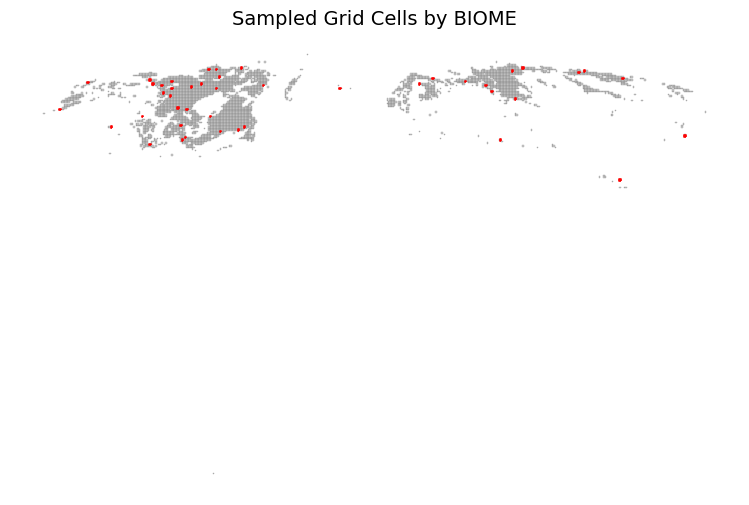

In [67]:
import matplotlib.pyplot as plt

# subset the selected cells
sel = filtered_grid[filtered_grid["cell_id"].isin(cell_ids_sample)]

# plot in Mollweide (keeps your native projection)
fig, ax = plt.subplots(figsize=(10, 6))
filtered_grid.plot(ax=ax, color="lightgray", edgecolor="gray", linewidth=0.2)
sel.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1.2)

ax.set_title("Sampled Grid Cells by BIOME", fontsize=14)
ax.set_axis_off()
plt.show()


In [ ]:
clip_pld_lakes_by_cells(
    grid_gdf_or_path=filtered_grid,
    cell_id_list=cell_ids,
    pld_gdb_path=r"E:\planetscope_lake_ice\Data\Input\PLD\SWOT_PLD_v201_02042025_attributes_updated.gdb",
    output_dir=output_dir,
    cell_id_field='cell_id',   # replace if your id column has a different name
    pld_layer_index=0,
    require_within=True,       # True -> lake must be fully within cell
    overwrite=True
)